![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Importación de librerías
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [57]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [58]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001


# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

j, split, gain = best_split(X, y, 5)

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
tree_predict(X, tree)



### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [59]:
# Celda 2

# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [62]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample,:]
    y_train = y_train.iloc[sample]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13990.0,14980.0,12488.0,12488.0,12489.0,12488.0,11995.0,12488.0,11995.0
326011,6492.0,5995.0,6492.0,6492.0,6492.0,6492.0,6999.0,6492.0,6492.0,6492.0
242354,16491.0,16491.0,16491.0,16491.0,16491.0,16491.0,16491.0,16491.0,16491.0,16491.0
266376,21990.0,21990.0,21990.0,15988.0,15988.0,15900.0,15900.0,15900.0,15900.0,15900.0
396954,15988.0,15988.0,15988.0,15988.0,15988.0,15988.0,15988.0,15988.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,15121.0,13836.0,17561.0,17561.0,16468.0,16468.0,16468.0,14999.0,16468.0
364521,15999.0,15999.0,14851.0,14851.0,15999.0,15999.0,16900.0,14851.0,14851.0,14851.0
120072,23533.0,23533.0,23533.0,17700.0,17700.0,17700.0,17700.0,17700.0,17700.0,17700.0
99878,12989.0,12989.0,12989.0,12989.0,12989.0,12989.0,12989.0,12989.0,12989.0,12989.0


In [63]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2094.921651442501
Árbol  2 tiene un error:  2143.588943820465
Árbol  3 tiene un error:  2091.5765590558344
Árbol  4 tiene un error:  2101.269034680839
Árbol  5 tiene un error:  2166.1579741770674
Árbol  6 tiene un error:  2167.965320861841
Árbol  7 tiene un error:  2160.523932246401
Árbol  8 tiene un error:  2160.7735197631982
Árbol  9 tiene un error:  2133.42356958019


In [64]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

257343    13038.1
326011     6493.0
242354    16491.0
266376    17744.6
396954    15988.0
           ...   
144298    15878.6
364521    15515.1
120072    19449.9
99878     12989.0
387162    11933.5
Length: 3464, dtype: float64

In [65]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

1862.899085321319

El modelo tiene un MSE de 1862.89, donde se evalúan 10 árboles de clasificación con muestras boostrap

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [13]:
# Celda 3
import sklearn
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

n_features=2
base_model = DecisionTreeRegressor(random_state=42,max_depth=5)

bagging_model = BaggingRegressor(base_estimator=base_model,n_estimators=10,max_features=np.log(n_features), random_state=42)
bagging_model.fit(X_train, y_train)

y_pred=bagging_model.predict(X_test)

#Desempeño del modelo
mae_bagging = mean_absolute_error(y_pred, y_test)
mse_bagging =  mean_squared_error(y_test, y_pred)
print('MSE:', mse_bagging)
print('Mean MAE:', mae_bagging)

MSE: 2632003.523413694
Mean MAE: 1209.2665406544402


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [14]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math as m
rf = RandomForestRegressor()
# Entrenamos el modelo
rf.fit(X_train, y_train)

RandomForestRegressor()

In [15]:
# Hacemos la prediccion y obervamos los resultados 
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print(f"Como vemos, el modelo ejecutado en promedio tiene un error de ${round(m.sqrt(mse),0)} en sus predicciones")

mae_randomforest = mean_absolute_error(y_pred, y_test)
print('Mean MAE:', mae_randomforest)

MSE: 3116576.6224043253
Como vemos, el modelo ejecutado en promedio tiene un error de $1765.0 en sus predicciones
Mean MAE: 1314.9560448858063


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [16]:
# Celda 5
# Primero vamos a calibrar el numero de estimadores
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
from sklearn.model_selection import cross_val_score
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
scores = []
for n in estimator_range:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    score = cross_val_score(rf, X, y, cv=5)
    scores.append(np.mean(score))
    print("Score promedio con %d estimadores: %f" % (n, scores[-1]))

Score promedio con 10 estimadores: 0.796329
Score promedio con 20 estimadores: 0.799568
Score promedio con 30 estimadores: 0.801205
Score promedio con 40 estimadores: 0.801851
Score promedio con 50 estimadores: 0.801703
Score promedio con 60 estimadores: 0.802111
Score promedio con 70 estimadores: 0.802207
Score promedio con 80 estimadores: 0.802282
Score promedio con 90 estimadores: 0.802244
Score promedio con 100 estimadores: 0.802207
Score promedio con 110 estimadores: 0.802395
Score promedio con 120 estimadores: 0.802344
Score promedio con 130 estimadores: 0.802462
Score promedio con 140 estimadores: 0.802640
Score promedio con 150 estimadores: 0.802671
Score promedio con 160 estimadores: 0.802629
Score promedio con 170 estimadores: 0.802583
Score promedio con 180 estimadores: 0.802581
Score promedio con 190 estimadores: 0.802599
Score promedio con 200 estimadores: 0.802603
Score promedio con 210 estimadores: 0.802515
Score promedio con 220 estimadores: 0.802520
Score promedio con 

Text(0, 0.5, 'Score')

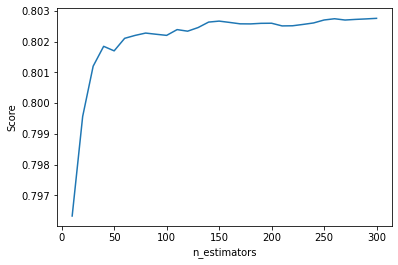

In [17]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, scores)
plt.xlabel('n_estimators')
plt.ylabel('Score')

Vemos que a aproximadamente a partir de los 150 estimadores, los resultados no cambian significativamente, por lo que este sera el numero de estimadores que vamos a usar

In [18]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
scores = []
for n in feature_range:
    rf = RandomForestRegressor(n_estimators=150, max_features=n, random_state=1, n_jobs=-1)
    score = cross_val_score(rf, X, y, cv=5)
    scores.append(np.mean(score))
    print("Score promedio con %d estimadores: %f" % (n, scores[-1]))

Score promedio con 1 estimadores: 0.796021
Score promedio con 2 estimadores: 0.796002
Score promedio con 3 estimadores: 0.796187
Score promedio con 4 estimadores: 0.796593
Score promedio con 5 estimadores: 0.797609
Score promedio con 6 estimadores: 0.798521
Score promedio con 7 estimadores: 0.800100
Score promedio con 8 estimadores: 0.801447
Score promedio con 9 estimadores: 0.802671


Text(0, 0.5, 'Score')

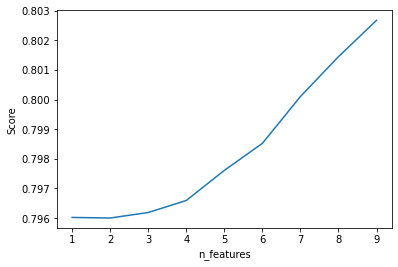

In [19]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(feature_range, scores)
plt.xlabel('n_features')
plt.ylabel('Score')

Como vemos, el modelo mejora a medida que vamos agregando variables, por lo que no podemos hacer un corte en el numero de variables del modelo

In [20]:
# Hacemos la prediccion con los parametros calibrados del modelo
rf = RandomForestRegressor(n_estimators=150, max_features = 9)
# Entrenamos el modelo
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred)
print("MSE:", mse1)
print(f"Como vemos, el modelo ejecutado en promedio tiene un error de ${round(m.sqrt(mse),0)} en sus predicciones")

MSE: 3113535.5462948303
Como vemos, el modelo ejecutado en promedio tiene un error de $1765.0 en sus predicciones


Si comparamos con el modelo ejecutado antes de la calibracion, vemos que no hay una diferencia significativa entre el uno y el otro. El primer modelo tenia un error de 1757 en promedio, y el calibrado de 1755 dolares

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [23]:
# Celda 6
#! pip install xgboost

from xgboost import XGBRegressor
boost = XGBRegressor()
boost.fit(X_train, y_train)
y_pred = boost.predict(X_test)

In [24]:
#Desempeño del modelo
mae_xg = mean_absolute_error(y_pred, y_test)
mse_xg =  mean_squared_error(y_test, y_pred)

print('Mean MSE_XGBoost:', mse_xg)
print('Mean MAE_XGBoost:', mae_xg )

Mean MSE_XGBoost: 2629001.844928506
Mean MAE_XGBoost: 1186.634392366123


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

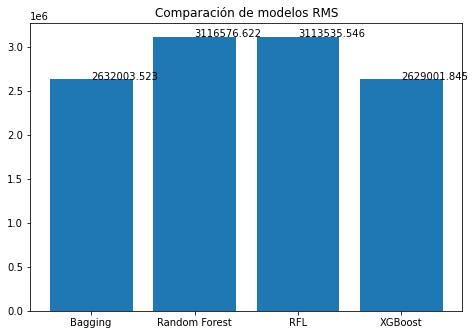

In [25]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#Asignamos el titulo
ax.set_title("Comparación de modelos RMS")

ejeX = [ 'Bagging','Random Forest','RFL', 'XGBoost']
ejeY = [round(mse_bagging,3),round(mse,3),round(mse1,3),round(mse_xg,3)]
ax.bar(ejeX,ejeY)

def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()
